In [25]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as spslinalg
import matplotlib.pyplot as plt
# %matplotlib inline

In [16]:
data, row, col = [1, 1], [0, 1], [0, 1]
Id = sparse.csr_matrix((data, (row, col)), shape=(2, 2))

data, row, col = [1, 1], [0, 1], [1, 0]
Sx = sparse.csr_matrix((data, (row, col)), shape=(2, 2))

data, row, col = [1, -1], [0, 1], [0, 1]
Sz = sparse.csr_matrix((data, (row, col)), shape=(2, 2))
print(Id.toarray(), Sx.toarray(), Sz.toarray(), sep='\n\n')

[[1 0]
 [0 1]]

[[0 1]
 [1 0]]

[[ 1  0]
 [ 0 -1]]


In [17]:
def getSigtensor(op, j, L):
    op_list = [Id]*L
    op_list[j] = op
    full = op_list[0]
    for i in op_list[1:]:
        full = sparse.kron(full, i, format='csr') # tensor product
    return full

def getSigZlist(L):
    # do not convert into np.array -> they become dense!
    return [getSigtensor(Sz, i, L) for i in range(L)]

def getSigXlist(L):
    return [getSigtensor(Sx, i, L) for i in range(L)]

In [18]:
# Test
L = 2
sx_list = getSigXlist(L)
for i in range(L):
    print(sx_list[i].toarray(), '\n')

[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]] 

[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]] 



In [19]:
# H = -J * sum0_L-1(sigXj * sigXj+1) - g * sum0_L-1(sigZj)
def gen_hamiltonian(sx_list, sz_list, g, J):
    H = -g * sum(sz_list) # do not use np.sum -> result becomes dense!
    
    for sx_i, sx_i2 in zip(sx_list[:-1], sx_list[1:]):
        H += -J * sx_i * sx_i2
    H += -J * sx_list[-1] * sx_list[0] # periodic boundary cond
    
    return H

In [20]:
L = 2
g, J = 0.1, 1
sz_list = getSigZlist(L)
sx_list = getSigXlist(L)

H = gen_hamiltonian(sx_list, sz_list, g, J)
print(H.toarray())

[[-0.2  0.   0.  -2. ]
 [ 0.   0.  -2.   0. ]
 [ 0.  -2.   0.   0. ]
 [-2.   0.   0.   0.2]]


In [26]:
k = 3
eigval, eigvec = spslinalg.eigsh(H, k, which='SA') # smallest algebraic eigevals

for i in range(k):
    print(np.around(eigval[i], 3), np.around(eigvec[:, i], 3))

-25.525 [-0.904 -0.    -0.    ...  0.    -0.    -0.   ]
-23.525 [-0.     0.261  0.261 ...  0.     0.     0.   ]
-23.046 [-0.     0.368  0.278 ... -0.     0.     0.   ]


In [27]:
Ls = np.arange(6, 13, 2)
gs = np.linspace(0, 2, 21)
J = 1.
Cs = [[] for _ in range(len(Ls))]
E1s = [[] for _ in range(len(Ls))]
E2s = [[] for _ in range(len(Ls))]

for i, L in enumerate(Ls):
    for g in gs:
        sz_list = getSigZlist(L)
        sx_list = getSigXlist(L)
        H = gen_hamiltonian(sx_list, sz_list, g, J)
        
        k = 3
        eigval, eigvec = spslinalg.eigsh(H, k, which='SA') # smallest algebraic eigevals
        
        ground = eigvec[:, 0]
        sx0, sxhalf = sx_list[0], sx_list[L//2]
        C = sx0 * sxhalf * ground
        C = np.inner(ground.conj(), C)
        
        Cs[i].append(C)
        E1s[i].append(eigval[1] - eigval[0])
        E2s[i].append(eigval[2] - eigval[0])

print(np.shape(Cs), np.shape(E1s), np.shape(E2s))
# print(np.around(Cs, 3))
# print(np.around(E1s, 3))
# print(np.around(E2s, 3))

(4, 21) (4, 21) (4, 21)


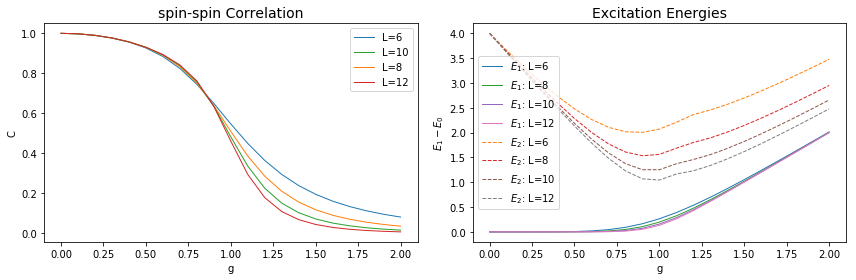

In [23]:
plt.figure(figsize=(12, 4), dpi=72)

ax1 = plt.subplot(1, 2, 1)
plt.xlabel('g', fontsize=10)
plt.ylabel('C', fontsize=10)
plt.title('spin-spin Correlation', fontsize=14)

ax2 = plt.subplot(1, 2, 2)
plt.xlabel('g', fontsize=10)
plt.ylabel('$E_1 - E_0$', fontsize=10)
plt.title('Excitation Energies', fontsize=14)

for i in range(len(Ls)):
    ax1.plot(gs, Cs[i], linewidth=1., label='L='+str(Ls[i]))

    ax2.plot(gs, E1s[i], linewidth=1., label='$E_1$: L='+str(Ls[i]))    
    ax2.plot(gs, E2s[i], '--', linewidth=1., label='$E_2$: L='+str(Ls[i]))

# change legend order
for ax in (ax1, ax2):
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[::2] + handles[1::2]
    labels = labels[::2] + labels[1::2]
    ax.legend(handles, labels)

plt.tight_layout() # subplot padding
plt.show()